this is the exploratory data analysis for the BTTAI Copy.AI project
    in this notebook, i'll be looking at the EPA data through all the stuff there is to do

In [1]:
# import bs as needed
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
# begin by loading a csv
    # start maybe with the daily aqi by cbsa 2024, just to get this working
# df = pd.read_csv("/data/aqi/daily_aqi_by_cbsa_2023.csv", header=0)
df = pd.read_csv(os.path.join(os.getcwd(), "data", "aqi", "daily_aqi_by_cbsa_2023.csv"), header=0)
df.head()

,CBSA,CBSA Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,"Aberdeen, SD",10100,2023-01-01,33,Good,PM2.5,46-013-0004,1
1,"Aberdeen, SD",10100,2023-01-02,56,Moderate,PM2.5,46-013-0004,1
2,"Aberdeen, SD",10100,2023-01-03,34,Good,PM2.5,46-013-0004,1
3,"Aberdeen, SD",10100,2023-01-04,10,Good,PM2.5,46-013-0004,1
4,"Aberdeen, SD",10100,2023-01-05,51,Moderate,PM2.5,46-013-0004,1


In [3]:
# yippie! it worked
# now let's find a way to trim this down to just the NYC stuff
df_nyc = df.loc[df['CBSA'] == 'New York-Newark-Jersey City, NY-NJ-PA']
df_nyc.head(10)

# now there's a file with AQI for NYC for all of 2024 so far
    # let's do the same for other types of data

,CBSA,CBSA Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
107643,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-01,57,Moderate,PM2.5,36-059-0005,33
107644,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-02,62,Moderate,PM2.5,36-103-0009,33
107645,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-03,78,Moderate,PM2.5,36-081-0124,36
107646,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-04,70,Moderate,PM2.5,36-081-0124,33
107647,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-05,64,Moderate,PM2.5,34-039-0004,32
107648,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-06,58,Moderate,PM2.5,36-061-0115,36
107649,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-07,53,Moderate,PM2.5,36-061-0115,33
107650,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-08,54,Moderate,PM2.5,36-103-0009,31
107651,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-09,59,Moderate,PM2.5,36-061-0115,35
107652,"New York-Newark-Jersey City, NY-NJ-PA",35620,2023-01-10,60,Moderate,PM2.5,34-029-2002,32


In [4]:
# this is the wind one, can then do the same things for temp, pressure, etc
    # the files all have the headers and general format
        # most of this isn't useful for us. the main thing is the 'arithmetic mean' column and date
            # once it's been cut down to just that, it can be merged with the others into one big (well-labled!) df
    # the unit is in there somewhere, but it should be consistent
        # might be good to normalize the values at some point

# df_wind = pd.read_csv(os.path.join(os.getcwd(), "data", "meteorological", "daily_WIND_2023.csv"), header=0)
# df_wind.head()
# # get the CBSA name to narrow it down to the NYC ones
# df_wind_nyc = df_wind.loc[df_wind['CBSA Name'] == 'New York-Newark-Jersey City, NY-NJ-PA']
# df_wind_nyc.head(10)

In [5]:
# ok so that's that! now there's a general idea for what to do, which is:
# download all these files down to 2019
    # have currently skipped 2024 because it's incomplete
# trim them to just the nyc stuff
# trim everything except parameter name, date local, arithmetic mean, state name, county name, CBSA name
    # keep all the location stuff for merging
    # can safely get rid of:
        # state code, county code, site number, parameter code, POC, latitude, longitude, datum, sample duration,
        # pollutant standard, units?, event type, observation count, observation percent, 1st max value, 1st max hour,
        # AQI (usually empty anyway), method code, method name, local site name, address, date of last change
            # don't need city name, will merge on county and call it a day
            # units can just be looked up
# split into separate dfs for the separate parameters
    # some of these have various measurements in one file
# relabel 'arithmetic mean' to be more descriptive
    # should be the parameter name, once split
# merge all of them based on...
    # location?
        # maybe start with county name, get all the stuff from one city in one place
        # then maybe merge it more as needed, if the cities are sufficiently close
            # might end up discarding the non-queens stuff?
            # once there's multiple values for one date for one type of data, will have to average them in some way
                # they can't just be merged away since the CBSA/col will be the same but the data will be different
            # not sure how to go about this, but for later
     # date local?
        # this would merge various locations all into one, may or may not be what's intended
# once it's all one big file with all the possibly necessary data that the EPA could give for every year 2019-23, we're good

In [6]:
def process_file(filename):
    # access file
    should_return = False
    try:
        df_new = pd.read_csv(filename, header=0)
    except:
        print("file not found! womp womp")
        should_return = True

    if should_return:
        return

    # for some reason, aqi has a different name for the column
    col_name = ''
    if 'aqi' in filename:
        col_name = 'CBSA'
    else:
        col_name = 'CBSA Name'
    
    # trim rows to just nyc
        # only rows with a "CBSA Name" of "New York-Newark-Jersey City, NY-NJ-PA"
    df_new_nyc = df_new.loc[df_new[col_name] == 'New York-Newark-Jersey City, NY-NJ-PA']
    #print(df_new_nyc.head())

    # trim columns to just useful
    # again, aqi is different
    if 'aqi' in filename:
        df_new_nyc = df_new_nyc.drop(['CBSA', 'CBSA Code', 'Defining Site', 'Number of Sites Reporting', 'Defining Parameter'], axis = 1)
    else:
        # trim everything except parameter name, date local, arithmetic mean, state name, county name, ~~city name~~, CBSA name
        df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \
                        axis = 1, inplace = True)
        df_new_nyc = df_new_nyc.rename(columns={'Date Local': 'Date'})
        df_new_nyc = df_new_nyc.rename(columns={'Arithmetic Mean': df_new_nyc.iloc[1,0]})
        df_new_nyc = df_new_nyc.drop(columns = 'Parameter Name')
    
    # return the final df
    return df_new_nyc

In [7]:
# take in the folder ("aqi") and base file name ("aqi_by_cbsa")
def process_file_set(folder, base_filename):
    whole_file_df = pd.DataFrame()
    # loop through all the years i have files for
    for i in range(2019, 2024):
        # append the year to the end of the filename, then call process_file
        filename = "daily_" + base_filename + "_" + str(i) + ".csv"

        filename = "/" + os.path.join("Users", "soarderius", "epa", "data", folder, filename)

        print(filename)
        df = process_file(filename) # have this be equal to something

        # once the thing was returned, start to merge it with the a big one for this folder
        try:
            whole_file_df = pd.concat([whole_file_df, df])
        except:
            print("couldn't concat! probably because file not found, which is fine")
        #print(whole_file_df.head())
    # return the folder one
    return whole_file_df

In [8]:
# do all of these then merge into the big big one

print(os.getcwd())

aqi = process_file_set('aqi', 'aqi_by_cbsa')
pressure = process_file_set('meteorological', 'PRESS')
new_big_file_df = pd.merge(aqi, pressure, how='outer', on='Date')

for i in ['42101', '42401', '42602', '44201']:
    new_big_file_df = pd.merge(new_big_file_df, process_file_set('criteria_gases', i), how='outer', on=['Date', 'County Name'])

for i in ['88101']:
    new_big_file_df = pd.merge(new_big_file_df, process_file_set('pm', i), how='outer', on=['Date', 'County Name'])

new_big_file_df = pd.merge(new_big_file_df, process_file_set('meteorological', 'TEMP'), how='outer', on=['Date', 'County Name'])

new_big_file_df = new_big_file_df.drop_duplicates(subset=['Date', 'County Name'])
new_big_file_df.to_csv('please_work_fr5.csv', sep=',', index=False, encoding='utf-8')

/Users/soarderius/epa
/Users/soarderius/epa/data/aqi/daily_aqi_by_cbsa_2019.csv
/Users/soarderius/epa/data/aqi/daily_aqi_by_cbsa_2020.csv
/Users/soarderius/epa/data/aqi/daily_aqi_by_cbsa_2021.csv
/Users/soarderius/epa/data/aqi/daily_aqi_by_cbsa_2022.csv
/Users/soarderius/epa/data/aqi/daily_aqi_by_cbsa_2023.csv
/Users/soarderius/epa/data/meteorological/daily_PRESS_2019.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/meteorological/daily_PRESS_2020.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/meteorological/daily_PRESS_2021.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/meteorological/daily_PRESS_2022.csv
file not found! womp womp
/Users/soarderius/epa/data/meteorological/daily_PRESS_2023.csv
file not found! womp womp
/Users/soarderius/epa/data/criteria_gases/daily_42101_2019.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42101_2020.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42101_2021.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42101_2022.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42101_2023.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42401_2019.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42401_2020.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42401_2021.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42401_2022.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42401_2023.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42602_2019.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42602_2020.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42602_2021.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42602_2022.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_42602_2023.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_44201_2019.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_44201_2020.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_44201_2021.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_44201_2022.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/criteria_gases/daily_44201_2023.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/pm/daily_88101_2019.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/pm/daily_88101_2020.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/pm/daily_88101_2021.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/pm/daily_88101_2022.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/pm/daily_88101_2023.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/meteorological/daily_TEMP_2019.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/meteorological/daily_TEMP_2020.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(filename, header=0)
/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/meteorological/daily_TEMP_2021.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/meteorological/daily_TEMP_2022.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


/Users/soarderius/epa/data/meteorological/daily_TEMP_2023.csv


/var/folders/v4/zyvy1vmn39ddql58q2r98k8h0000gn/T/ipykernel_6616/1873084212.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_nyc.drop(df_new_nyc.columns.difference(['Parameter Name','Date Local', 'Arithmetic Mean', 'County Name']), \


In [9]:
# big file now exists! leave it as is, edit the dataframe, then make a new file that's final (and has a proper name)
final_df = new_big_file_df

print(final_df.columns)

Index(['Date', 'AQI', 'Category', 'Barometric pressure', 'County Name',
       'Carbon monoxide', 'Sulfur dioxide', 'Nitrogen dioxide (NO2)', 'Ozone',
       'PM2.5 - Local Conditions', 'Outdoor Temperature'],
      dtype='object')


In [10]:
# drop duchess, kings, ocean, putnam, and richmond
final_df.drop(final_df.loc[final_df['County Name'] == 'Dutchess'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Hunterdon'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Kings'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Middlesex'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Monmouth'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Morris'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Nassau'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'New York'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Ocean'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Orange'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Passaic'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Putnam'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Richmond'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Rockland'].index, inplace=True)
final_df.drop(final_df.loc[final_df['County Name'] == 'Westchester'].index, inplace=True)

print(final_df['County Name'].unique())

final_df.head(30)

#final_df.to_csv('with_removals.csv', sep=',', index=False, encoding='utf-8')

['Bergen' 'Bronx' 'Essex' 'Hudson' 'Queens' 'Suffolk' 'Union' nan]


,Date,AQI,Category,Barometric pressure,County Name,Carbon monoxide,Sulfur dioxide,Nitrogen dioxide (NO2),Ozone,PM2.5 - Local Conditions,Outdoor Temperature
0,2019-01-01,54.0,Moderate,999.337500,Bergen,0.182609,NaN,9.991667,NaN,7.140909,47.416667
4,2019-01-01,54.0,Moderate,1007.583333,Bronx,0.271042,0.408333,13.570833,0.019118,6.133333,50.233333
518,2019-01-01,NaN,NaN,NaN,Essex,0.283913,0.000000,10.833333,0.024471,4.570833,NaN
526,2019-01-01,54.0,Moderate,1010.195833,Hudson,0.204167,0.225000,10.683333,0.024235,3.600000,48.875000
588,2019-01-01,54.0,Moderate,1005.750000,Queens,0.227208,0.087500,10.491667,0.022235,3.400000,50.583333
638,2019-01-01,54.0,Moderate,1010.833333,Suffolk,NaN,0.000000,2.400000,0.022941,NaN,NaN
644,2019-01-01,54.0,Moderate,1009.937500,Union,0.091304,0.304167,8.970833,NaN,5.600000,50.000000
725,2019-01-02,68.0,Moderate,1012.479167,Bergen,0.178261,NaN,17.645833,NaN,7.541667,35.125000
729,2019-01-02,68.0,Moderate,1021.125000,Bronx,0.254792,0.850000,18.737500,0.010647,7.187500,37.587500
1243,2019-01-02,NaN,NaN,NaN,Essex,0.282913,0.254167,19.612500,0.009412,5.341667,NaN


In [11]:
# replace any aqi/category nans with whatever value is present for that date
cols = ['AQI', 'Category']
final_df.loc[:,cols] = final_df.loc[:,cols].bfill()

#final_df.to_csv('aqi_fix3.csv', sep=',', index=False, encoding='utf-8')

In [12]:
# then drop any rows with a nan county
final_df = final_df.dropna(subset=['County Name'])

#final_df.to_csv('aqi_fix4.csv', sep=',', index=False, encoding='utf-8')

In [13]:
# group by date 
averaged_df = final_df.groupby('Date', as_index=False).mean(numeric_only=True)

#averaged_df.to_csv('grouped_by_date.csv', sep=',', index=False, encoding='utf-8')

In [14]:
# drop pressure column (sorry, too many nans)
averaged_df = averaged_df.drop(columns='Barometric pressure')

#averaged_df.to_csv('final_file.csv', sep=',', index=False, encoding='utf-8')

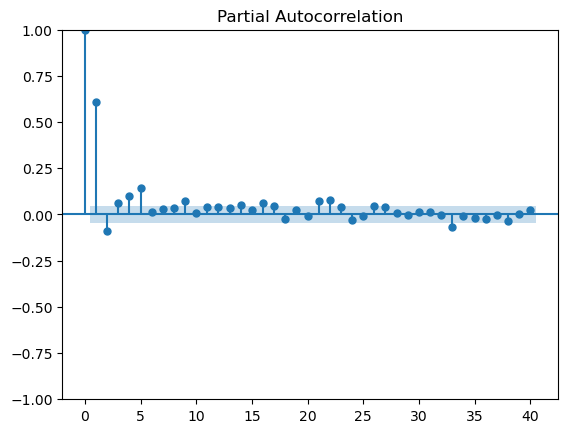

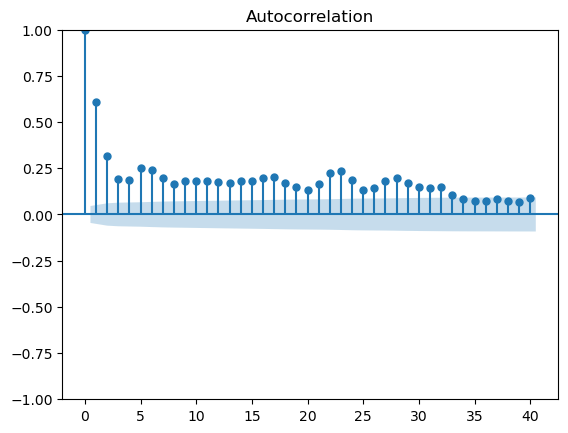

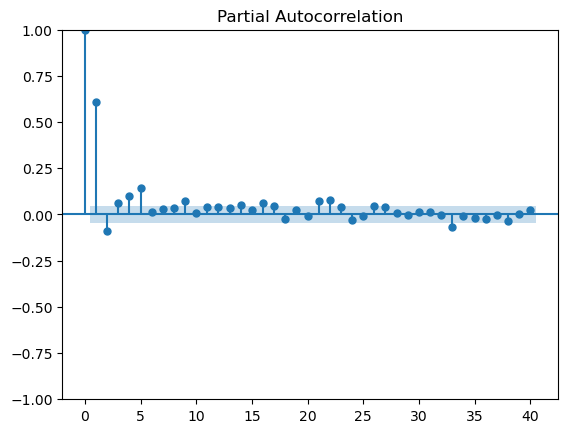

In [15]:
plot_acf(averaged_df["AQI"], lags=40)
plot_pacf(averaged_df["AQI"], lags=40)

In [16]:
# Fit the ARIMA model
# Initial ARIMA Model parameters
p, d, q = 1, 0, 1
model = ARIMA(averaged_df["AQI"], order=(p, d, q))
model_fit = model.fit()
model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7669.335
Date:                Thu, 05 Dec 2024   AIC                          15346.669
Time:                        21:05:11   BIC                          15368.709
Sample:                             0   HQIC                         15354.799
                               - 1826                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.5334      1.142     52.145      0.000      57.296      61.771
ar.L1          0.5078      0.023     22.449      0.000       0.463       0.552
ma.L1          0.1591      0.025      6.402      0.000       0.110       0.208
sigma2       260.3420      4.738     54.946      0.000     251.055     269.629
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6099.53
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             1.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
data = averaged_df["AQI"]
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit the model to training data. Replace p, d, q with our ARIMA parameters
model = ARIMA(averaged_df["AQI"], order=(p, d, q))  

# Forecast
forecast = model_fit.forecast(steps=len(test))

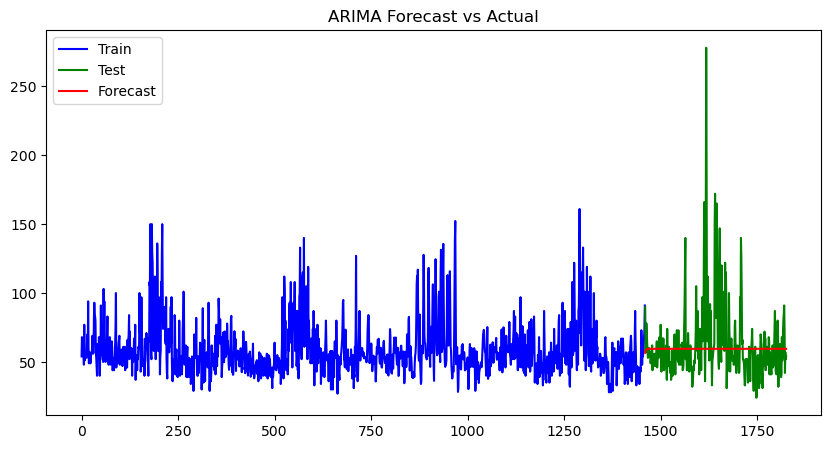

In [18]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data.index[:train_size], train, label='Train', color='blue')
plt.plot(data.index[train_size:], test, label='Test', color='green')
plt.plot(data.index[train_size:], forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

The Autocorrelation plot for the data is:


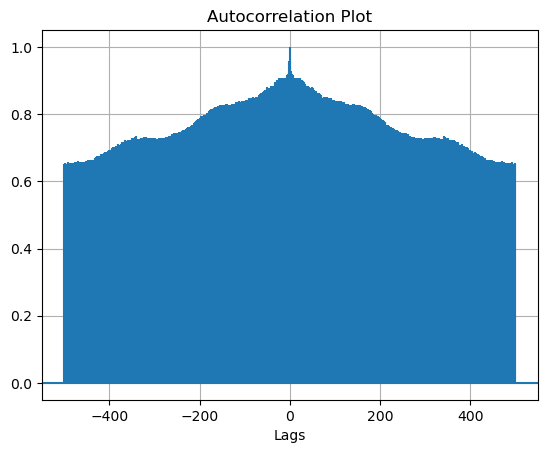

In [19]:
plt.title("Autocorrelation Plot") 
 
# Providing x-axis name.
plt.xlabel("Lags") 
 
# Plotting the Autocorrelation plot.
plt.acorr(averaged_df["AQI"], maxlags = 500) 
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show() 

In [20]:
X = averaged_df["AQI"]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t + 1205]
	history.append(obs)
	print(t, 'predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

0 predicted=41.185094, expected=48.000000
1 predicted=48.402981, expected=54.000000
2 predicted=50.029134, expected=47.000000
3 predicted=44.146884, expected=42.000000
4 predicted=41.439566, expected=50.000000
5 predicted=48.073546, expected=48.000000
6 predicted=48.142447, expected=57.000000
7 predicted=55.010968, expected=35.000000
8 predicted=37.612978, expected=45.000000
9 predicted=46.719463, expected=48.000000
10 predicted=47.533739, expected=49.000000
11 predicted=49.335235, expected=64.000000
12 predicted=58.633777, expected=56.000000
13 predicted=50.901022, expected=40.000000
14 predicted=42.915030, expected=57.000000
15 predicted=55.721838, expected=44.000000
16 predicted=46.387199, expected=49.000000
17 predicted=52.509999, expected=48.000000
18 predicted=47.791581, expected=43.000000
19 predicted=44.639137, expected=74.000000
20 predicted=67.039639, expected=61.000000
21 predicted=55.102785, expected=57.000000
22 predicted=55.827714, expected=49.000000
23 predicted=49.07084

NameError: name 'pyplot' is not defined

In [21]:
# Plot the data
time_series.plot(title="Time Series Data")
plt.show()

# Perform ADF test
adf_result = adfuller(time_series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

# Check p-value
if adf_result[1] < 0.05:
    print("The series is stationary (reject H₀).")
else:
    print("The series is not stationary (fail to reject H₀).")
    # First differencing
    diff1 = time_series.diff().dropna()
    print("\nFirst Differenced Series:")
    adf_result = adfuller(diff1)
    print("p-value:", adf_result[1])

# Fit ARIMA model
model = ARIMA(time_series, order=(1, 0, 1))
fitted_model = model.fit()

# Print summary
print(fitted_model.summary())

# Forecast
forecast = fitted_model.forecast(steps=200)  # Predict next 10 time steps
print("Forecast:", forecast)

# Plot the original series and forecast
time_series.plot(label="Original")
plt.plot(range(len(time_series), len(time_series) + 200), forecast, label="Forecast", color='orange')
plt.legend()
plt.show()

NameError: name 'time_series' is not defined

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(time_series.diff().dropna(), lags=20)
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(time_series, model='additive', period=365)  # Adjust 'period' for known seasonality
result.plot()
plt.show()

In [ ]:
print("hi")

from statsmodels.tsa.statespace.sarimax import SARIMAX

time_series = averaged_df["AQI"]

print("hi")

# Fit SARIMA model
sarima_model = SARIMAX(time_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 365))

print("hi")

fitted_sarima = sarima_model.fit()

print("hi")

# Print summary
print(fitted_sarima.summary())

# Forecast
forecast = fitted_sarima.forecast(steps=365)  # Predict the next year
time_series.plot(label="Original")
plt.plot(range(len(time_series), len(time_series) + 365), forecast, label="Forecast", color="orange")
plt.legend()
plt.show()

hi
hi
hi


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
